In [14]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
import sys
import h5py
LAMBDA_LYA = 1215.67

Re-define these functions below, because Jupyter is unhappy importing them from functions.py:

In [15]:
def calculate_estnorm(W, R, L):
    '''
    W (np.ndarray): vector length N, average FFT of the weights
    R (np.ndarray): vector length N, resolution in Fourier space
    L (float): length of the spectra (in physical units, e.g. Angstroms or Mpc)
    Returns:
    estnorm (np.ndarray): vector length N, to be multiplied by every P1D mode of the measurement
    '''
    R2 = R.real**2 + R.imag**2
    denom = np.absolute(np.fft.ifft(np.fft.fft(W)* np.fft.fft(R2)))
    estnorm = np.absolute(L/denom)
    return estnorm

def calculate_window_matrix(W, R, L):

    '''
    W (np.ndarray): average of (w1) conj(w2) where w1 and w2 are FFT of original weights per skewer
    R (np.ndarray): vector length N, resolution in Fourier space
    L (float): physical length of skewers (e.g., in Angstroms)
    Returns:
    window_matrix (np.ndarray): window matrix to be convolved with pure theory
    estnorm (np.ndarray): vector length N, to be multiplied by every P1D mode of the measurement
    '''
    R2 = R.real**2 + R.imag**2
    denom = np.absolute(np.fft.ifft(np.fft.fft(W)* np.fft.fft(R2)))
    estnorm = np.absolute(L/denom)
    N = estnorm.size
    window_matrix = np.zeros((N,N))
    for m in range(N):
        for n in range(N):
            window_matrix[m,n] = W[m-n]*R2[n] / denom[m]
    return window_matrix, estnorm


def masked_theory(window_matrix, model):
    return np.matmul(window_matrix, model)
    

In [ ]:
# make a class for the output data
class Px_meas:
    """ Class to store the Px measurements """
    def __init__(self):
        self.p1d = None
        self.k_arr = None
        self.N_fft = None
        self.dvel = None
        self.N_skewers = None
        self.px = []
        self.px_var = []
        self.px_weights = []
        self.theta_bins = []
        return

    def read_hdf5(self, path, nmodes=None):
        with h5py.File(path, 'r') as f:
            print(f.keys())
             # Load shared datasets
            self.k_arr = f['k_arr'][:]
            self.p1d = f['p1d'][:]
            # self.p1d_weights = f['p1d_weights'][:]
            # Load attributes
            self.z = f.attrs['z']
            self.dz = f.attrs['dz']

            # Loop over all theta groups
            # sort only the theta_* groups
            theta_keys = sorted([key for key in f.keys() if key.startswith('theta_')],
                            key=lambda k: float(k.split('_')[1]))  # sort by theta_min in arcmin

            for key in theta_keys:
                g = f[key]
                self.px.append(g['px'][:])
                self.px_var.append(g['px_var'][:])
                self.px_weights.append(g['px_weights'][:])
                
                self.theta_bins.append((g.attrs['theta_min'], g.attrs['theta_max']))
                
            self.theta_bins = np.degrees(self.theta_bins) # convert from radian to deg
            self.px = np.asarray(self.px)
            self.px_weights = np.asarray(self.px_weights)
            self.px_var = np.asarray(self.px_var)
            self.mean_ang_separation = np.average(self.theta_bins, axis=1)
            if nmodes:
                self.px = self.px[:,:nmodes]
                self.px_var = self.px_var[:,:nmodes]
                self.k_arr = self.k_arr[:nmodes]
        return    

In [26]:
PxMocks_22 = Px_meas()
PxMocks_22.read_hdf5("/Users/ssatyavolu/projects/DESI/Y3_Lya_Px/px-nhp_41_zbin_2.2.hdf5") # input path to the test file


<KeysViewHDF5 ['k_arr', 'p1d', 'theta_1_5', 'theta_5_10']>


In [ ]:
from Lya_Px.input_power import InputPower
input_p=InputPower(P0=.5,k0=0.01,kF=0.1,f_px=0.7) # make sure to put in the same input power as the gauss_test uses (in px_from_pix.py)
gaussp1d = input_p.get_true_p1d(PxMocks_22.k_arr[:512])
gausspx = gaussp1d*.7
N = PxMocks_22.px_weights[1].shape[0]
fft_avg_res = np.ones(N)
L = N*0.8
dx = L/N
window_matrix, estnorm = calculate_window_matrix(PxMocks_22.px_weights[0], fft_avg_res, L) # PxMocks_22.px_weights[0]
masked_pred = masked_theory(window_matrix[:512,:512], gausspx)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 512 is different from 1024)

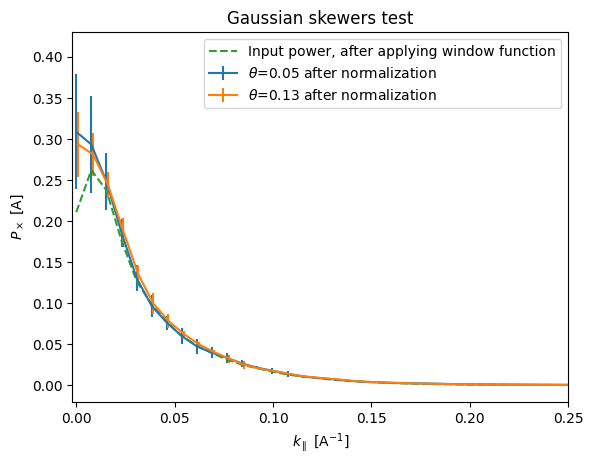

In [28]:
# plt.plot(PxMocks.k_arr, PxMocks.p1d)
for i in range(len(PxMocks_22.px)):
    x_offset_for_plotting = np.random.random(1)/500*i
    plt.errorbar(PxMocks_22.k_arr[:300]+x_offset_for_plotting, PxMocks_22.px[i][:300]*estnorm[:300], label=fr"$\theta$={PxMocks_22.mean_ang_separation[i]:.2} after normalization", yerr=estnorm[:300]*np.sqrt(PxMocks_22.px_var[i][:300]))
plt.plot(PxMocks_22.k_arr[:512], masked_pred, label='Input power, after applying window function', linestyle='dashed')
plt.title("Gaussian skewers test")
plt.xlim([-.002,.25])
plt.ylim([-.02,.43])
plt.ylabel(r"$P_\times$ [A]")
plt.xlabel(r"$k_\parallel$ [A$^{-1}$]")
plt.legend()
